In [117]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import lib

EPS = 1e-8

In [112]:
k = 100
tau = .9

Z_params = tf.Variable(
    tf.zeros(
        shape=(100,1),
        dtype=tf.float32
    )
)

probs = tf.sigmoid(Z_params)
pis = tf.stack((probs, 1-probs), axis=2)
g = tf.placeholder(tf.float32, shape=pis.shape, name='g')
Z = lib.gumbel_soft(pis, g, tau = tau)[:,:,0]

logp = lambda z: lib.binary_max_ent(Z, tau=tau)
# Negative KL between max ent and latent posterior
Negentropy = tf.reduce_mean(tf.einsum('ij,ij->i', Z, tf.stop_gradient(lib.phi_star(Z, logp))))

Loss = -Negentropy
solver = tf.train.AdagradOptimizer(learning_rate = 1e-3).minimize(Loss, var_list=Z_params)

0.453357


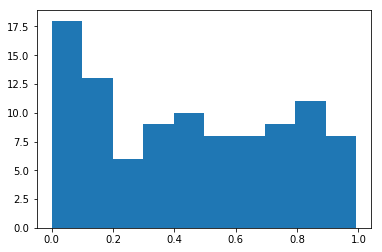

In [113]:
init = tf.global_variables_initializer()
sess = tf.Session()
with sess.as_default():
    sess.run(init)
    negents = []
    g_samp = np.random.gumbel(size=(k, 1, 2))
    Z_samp = sess.run(Z, feed_dict={g:g_samp})
    print(np.mean(Z_samp))
    plt.hist(Z_samp)
    for i in range(1000):
        g_samp = np.random.gumbel(size=(k, 1, 2))
        _, negent_curr = sess.run([solver, Negentropy], feed_dict = {g: g_samp})
        negents.append(negent_curr)
    g_samp = np.random.gumbel(size=(k, 1, 2))
    Z_samp = sess.run(Z, feed_dict={g:g_samp})

(array([ 17.,  11.,   8.,  11.,   8.,   9.,   7.,   5.,  10.,  14.]),
 array([ 0.0037953 ,  0.1032563 ,  0.2027173 ,  0.3021783 ,  0.40163929,
         0.50110029,  0.60056129,  0.70002229,  0.79948328,  0.89894428,
         0.99840528]),
 <a list of 10 Patch objects>)

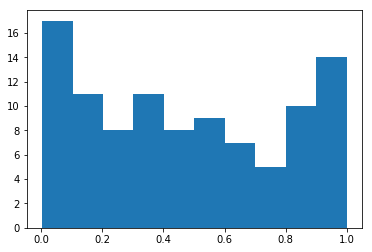

In [114]:
plt.hist(Z_samp)

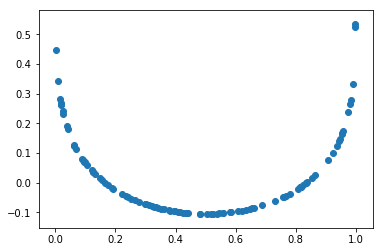

In [115]:
pdf = sess.run(logp(Z_samp), feed_dict={g:g_samp})
plt.scatter(Z_samp, pdf)

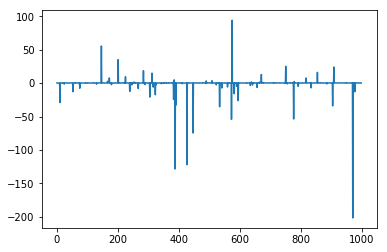

In [116]:
plt.plot(negents)

# Column entropy

In [507]:
n = 100

h = tf.Variable(tf.random_normal(
    shape=(1,n),
    mean=0,
    stddev=1.0,
    dtype=tf.float32
))
p = tf.nn.sigmoid(h)
p_avg = tf.reduce_mean(p)
ent = -(p_avg*tf.log(p_avg+EPS) + (1-p_avg)*tf.log(1-p_avg+EPS)) * 1.442695

solver = tf.train.AdamOptimizer(learning_rate = 1e-3).minimize(ent, var_list=h)

In [508]:
init = tf.global_variables_initializer()
sess = tf.Session()
with sess.as_default():
    sess.run(init)
    ents = []
    ps = []
    p_avgs = []
    print(sess.run(tf.reduce_mean(p)))
    for i in range(5000):
        _, ent_curr, p_curr, p_avg_curr = sess.run([solver, ent, p, p_avg])
        ents.append(ent_curr)
        ps.append(p_curr)
        p_avgs.append(p_avg_curr)

0.478213


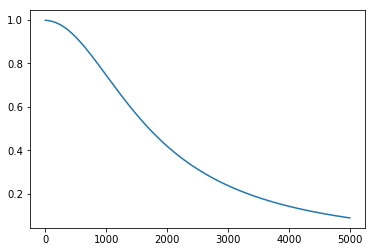

In [509]:
plt.plot(ents)

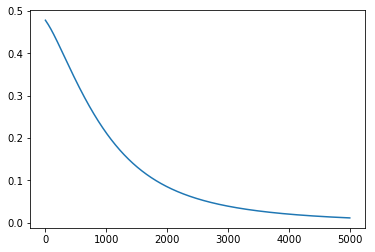

In [510]:
plt.plot(p_avgs)

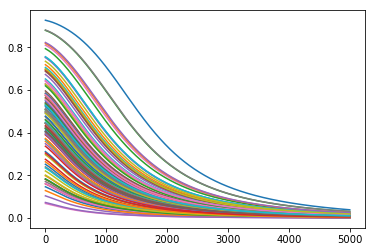

In [511]:
p_plot = plt.plot(np.reshape(ps, (-1,n)))